##### The University of Melbourne, School of Computing and Information Systems
### COMP30027 Machine Learning, 2022 Semester 1

# Assignment 2: Sentiment Classification of Tweets

**Full Name:** `Xavier Travers`

**Student ID:** `1178369`

### Import the necessary dependencies

In [195]:
# utilities
import re
import numpy as np
import pandas as pd
from collections import Counter
import string

# plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


### Read both the `.csv` files
Extract the sentiments and tweets as well

In [196]:
train_df = pd.read_csv("../datasets/Train.csv", sep=',')
test_df = pd.read_csv("../datasets/Test.csv", sep=',')


### Explore and analyze the data

In [197]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21802 entries, 0 to 21801
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  21802 non-null  int64 
 1   id          21802 non-null  int64 
 2   text        21802 non-null  object
 3   sentiment   21802 non-null  object
dtypes: int64(2), object(2)
memory usage: 681.4+ KB


In [198]:
train_df.head()


,Unnamed: 0,id,text,sentiment
0,2,805582613687713000,doctors hit campaign trail as race to medical...,neutral
1,3,637480203497832000,is anybody going to the radio station tomorro...,positive
2,4,641096279930507000,i just found out naruto didn't become the 5th...,neutral
3,5,625730917647126000,"""prince george reservist who died saturday ju...",neutral
4,6,633292370906230000,season in the sun versi nirvana rancak gak..s...,positive


In [199]:
train_df.sample(5)


,Unnamed: 0,id,text,sentiment
8328,10651,640440582595178000,gucci trousers jiva untimidness november actu...,neutral
8568,10950,638007301509505000,"""nyt editorial claims john kasich might be ap...",neutral
4332,5541,637461445811179000,"""katy perry's last friday night speaks to me....",positive
1384,1778,641242351164387000,msnbc: the nfl season kicks off thursday nigh...,neutral
7881,10062,802361909852983000,label scan of bob dylan's can you please craw...,neutral


In [200]:
# column names
print(train_df.columns)

# data lengths
print(f"Length of training data: \t{len(train_df)}")
print(f"Length of testing data: \t{len(test_df)}")

# shape of the data set
print(train_df.shape)

# Sentiment options and counts
print(Counter(train_df[['sentiment']].values[:, 0]))


Index(['Unnamed: 0', 'id', 'text', 'sentiment'], dtype='object')
Length of training data: 	21802
Length of testing data: 	6099
(21802, 4)
Counter({'neutral': 12659, 'positive': 5428, 'negative': 3715})


<AxesSubplot:title={'center':'Distribution over the sentiments'}, xlabel='Sentiment', ylabel='Frequency'>

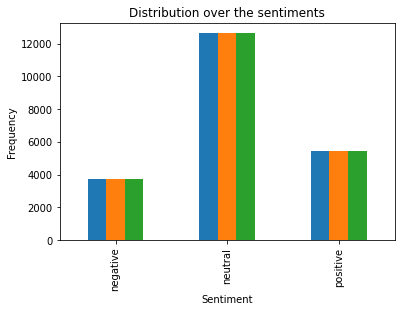

In [201]:
# Distribution of the data between the sentiments
train_df.groupby('sentiment').count().plot(kind='bar',
                                           title='Distribution over the sentiments', legend=False,
                                           xlabel='Sentiment', ylabel='Frequency')


### Pre-process the data
The tweets raw are full of noise.
This can be reduced via removal of punctuation, tokenization, stemming and/or lemmatization.

In [202]:
train_data = train_df[['text', 'sentiment']].copy()
train_data.head(20)

,text,sentiment
0,doctors hit campaign trail as race to medical...,neutral
1,is anybody going to the radio station tomorro...,positive
2,i just found out naruto didn't become the 5th...,neutral
3,"""prince george reservist who died saturday ju...",neutral
4,season in the sun versi nirvana rancak gak..s...,positive
5,if i didnt have you i'd never see the sun. #m...,positive
6,this is cute. #thisisus @nbcthisisus https://...,positive
7,today is the international day for the elimin...,neutral
8,"""in his first game back since april 14, david...",neutral
9,josh hamilton flies out to center... we are g...,neutral


In [203]:
# clean and remove urls
def remove_links(text):
    return re.sub(r"https?://t.co/\w*", " ", text)
train_data['text'] = train_data['text'].apply(lambda text: remove_links(text))
train_data.head(20)

,text,sentiment
0,doctors hit campaign trail as race to medical...,neutral
1,is anybody going to the radio station tomorro...,positive
2,i just found out naruto didn't become the 5th...,neutral
3,"""prince george reservist who died saturday ju...",neutral
4,season in the sun versi nirvana rancak gak..s...,positive
5,if i didnt have you i'd never see the sun. #m...,positive
6,this is cute. #thisisus @nbcthisisus,positive
7,today is the international day for the elimin...,neutral
8,"""in his first game back since april 14, david...",neutral
9,josh hamilton flies out to center... we are g...,neutral


In [204]:
# clean and remove non alphanumeric characters
def remove_nonwords(text):
    return re.sub(r"\W", " ", text)
train_data['text'] = train_data['text'].apply(lambda text: remove_nonwords(text))
train_data.head(20)

,text,sentiment
0,doctors hit campaign trail as race to medical...,neutral
1,is anybody going to the radio station tomorro...,positive
2,i just found out naruto didn t become the 5th...,neutral
3,prince george reservist who died saturday ju...,neutral
4,season in the sun versi nirvana rancak gak s...,positive
5,if i didnt have you i d never see the sun m...,positive
6,this is cute thisisus nbcthisisus,positive
7,today is the international day for the elimin...,neutral
8,in his first game back since april 14 david...,neutral
9,josh hamilton flies out to center we are g...,neutral


In [205]:
# remove numeric values
def remove_numeric(text):
    return re.sub(r"\d", " ", text)
train_data['text'] = train_data['text'].apply(lambda text: remove_numeric(text))
train_data.head(20)

,text,sentiment
0,doctors hit campaign trail as race to medical...,neutral
1,is anybody going to the radio station tomorro...,positive
2,i just found out naruto didn t become the th...,neutral
3,prince george reservist who died saturday ju...,neutral
4,season in the sun versi nirvana rancak gak s...,positive
5,if i didnt have you i d never see the sun m...,positive
6,this is cute thisisus nbcthisisus,positive
7,today is the international day for the elimin...,neutral
8,in his first game back since april david...,neutral
9,josh hamilton flies out to center we are g...,neutral


In [206]:
# remove non-alphabetic values
def remove_nonalphabetic(text):
    return re.sub(r"[^a-z]+", " ", text)
train_data['text'] = train_data['text'].apply(lambda text: remove_nonalphabetic(text))
train_data.head(20)

,text,sentiment
0,doctors hit campaign trail as race to medical...,neutral
1,is anybody going to the radio station tomorro...,positive
2,i just found out naruto didn t become the th ...,neutral
3,prince george reservist who died saturday jus...,neutral
4,season in the sun versi nirvana rancak gak sl...,positive
5,if i didnt have you i d never see the sun mtv...,positive
6,this is cute thisisus nbcthisisus,positive
7,today is the international day for the elimin...,neutral
8,in his first game back since april david wrig...,neutral
9,josh hamilton flies out to center we are goin...,neutral


In [207]:
# remove directly repeated values (OPTIONAL)
def remove_repeated(text):
    return re.sub(r"(.)\1+", r"\1", text)
# train_data['text'] = train_data['text'].apply(lambda text: remove_repeated(text))
# train_data.head(20)

In [213]:
# define the stop_words (first by guessing a few, 
# then by repeatedly finding the most common words below)
alphabet = 'abcdefghijklmnopqrstuvwxyz'
stop_words = [
    'the', 'th', 'this', 'to', 'you', 'and', 'in', 'is', 'will', 'that', 'on', 
    'of', 'just', 'it', 'for', 'be', 'at', 'about', 'going', 'yours', 'youre', 
    'your', 'youve', 'im', 'yet', 'yes', 'theres', 'about', 'he', 'her',
    'she', 'him', 'as', 'out', 'to', 'didn', 'who', 'whom', 'we',
    'we', 're', 'see', 'st', 'll', 'time', 'all', 'my', 'if'
    ] + [c for c in alphabet]

# clean the texts of stop words
def remove_stopwords(text):
    re_stop_words = r"(?<=\W)" + r"(?=\W)|(?<=\W)".join(stop_words) + r"(?=\W)"
    return re.sub(re_stop_words, " ", text)
train_data['text'] = train_data['text'].apply(lambda text: remove_stopwords(text))
train_data.head(20)

,text,sentiment
0,doctors hit campaign trail race medical c...,neutral
1,anybody radio station tomorrow sh...,positive
2,found naruto become hokage,neutral
3,prince george reservist died saturday wan...,neutral
4,season sun versi nirvana rancak gak slow ...,positive
5,didnt have never sun mtvstars l...,positive
6,cute thisisus nbcthisisus,positive
7,today international day elimination ...,neutral
8,his first game back since april david wrigh...,neutral
9,josh hamilton flies center are bo...,neutral


In [214]:
# remove repeated space characters
def reduce_spacing(text):
    return re.sub(r"\s+", " ", text)
train_data['text'] = train_data['text'].apply(lambda text: remove_stopwords(text))
train_data.head(20)

,text,sentiment
0,doctors hit campaign trail race medical c...,neutral
1,anybody radio station tomorrow sh...,positive
2,found naruto become hokage,neutral
3,prince george reservist died saturday wan...,neutral
4,season sun versi nirvana rancak gak slow ...,positive
5,didnt have never sun mtvstars l...,positive
6,cute thisisus nbcthisisus,positive
7,today international day elimination ...,neutral
8,his first game back since april david wrigh...,neutral
9,josh hamilton flies center are bo...,neutral


### Determine the most popular words per sentiment using `wordcloud`

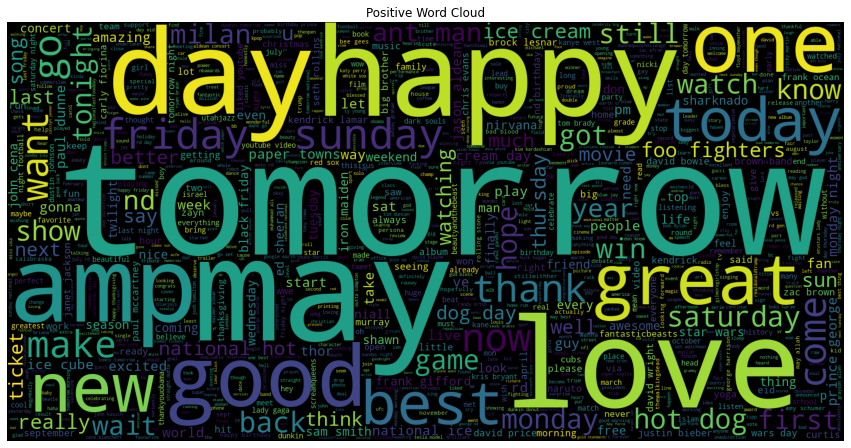

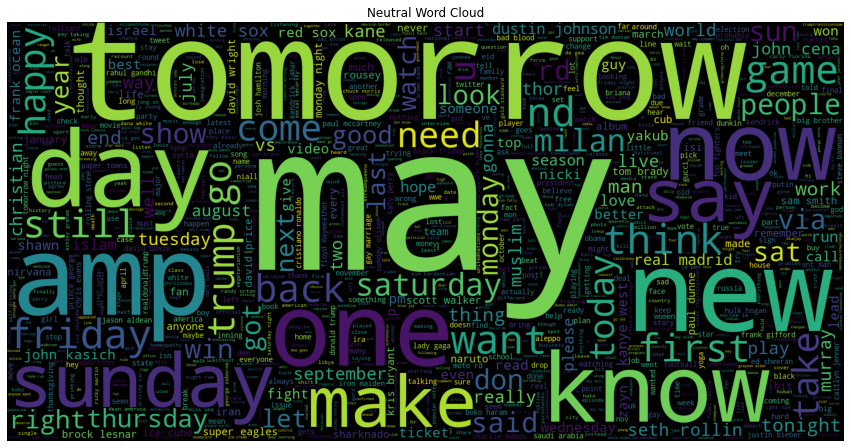

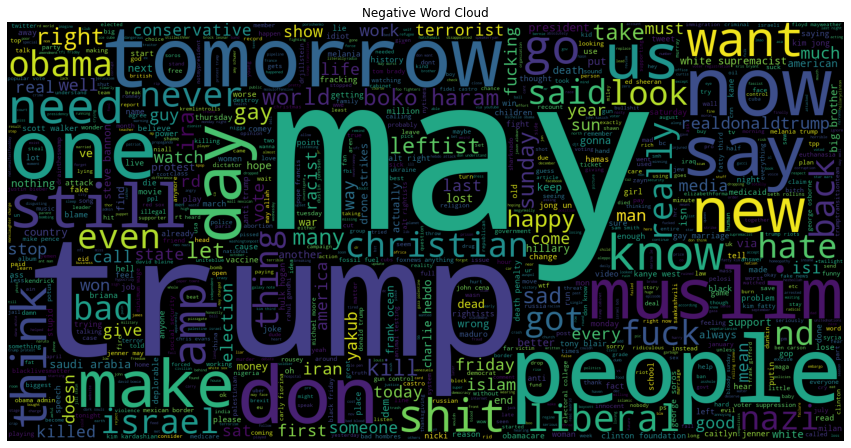

In [215]:
train_pos = train_data[train_data['sentiment'] == 'positive']
train_neu = train_data[train_data['sentiment'] == 'neutral']
train_neg = train_data[train_data['sentiment'] == 'negative']

wc_pos = WordCloud(max_words = 1000, width=1600, height=800
    ).generate(" ".join(train_pos['text']))
plt.figure(figsize= (15, 15), frameon=False)
plt.axis('off')
plt.title("Positive Word Cloud")
plt.imshow(wc_pos)
plt.savefig("../report/img/wc_positive.png", bbox_inches='tight')

wc_neu = WordCloud(max_words = 1000, width=1600, height=800
    ).generate(" ".join(train_neu['text']))
plt.figure(figsize= (15, 15), frameon=False)
plt.axis('off')
plt.title("Neutral Word Cloud")
plt.imshow(wc_neu)
plt.savefig("../report/img/wc_neutral.png", bbox_inches='tight')

wc_neg = WordCloud(max_words = 1000, width=1600, height=800
    ).generate(" ".join(train_neg['text']))
plt.figure(figsize= (15, 15), frameon=False)
plt.axis('off')
plt.title("Negative Word Cloud")
plt.imshow(wc_neg)
plt.savefig("../report/img/wc_negative.png", bbox_inches='tight')

### Vectorize the data using TF-IDF

In [221]:
# create the vectorizer
vectorizer = TfidfVectorizer(max_features=4000)

# apply it to the dataset
vectorizer.fit(train_data['text'])
X = vectorizer.transform(train_data['text'])
y = train_data['sentiment']

### Create a method to evaluate the models created

In [229]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def evaluate(model, X, y, cv = 5, display = True):

    # Create the output list for evaluations
    output = []

    if display:
        print(type(model))

    for i in range(cv):
        # create the dictionary of summaries
        cv_dict = dict()
        
        # extract the split
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
            test_size= 1 / cv, random_state=101)

        # fit the data and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # generate the evaluation statistics
        c_report = classification_report(y_test, y_pred)

        # display the confusion matrix
        c_matrix = confusion_matrix(y_test, y_pred)

        # append all of this to the dictionary
        cv_dict['data'] = (X_train, X_test, y_train, y_test, y_pred)
        cv_dict['evaluation'] = c_report
        cv_dict['confusion-matrix'] = c_matrix
        output.append(cv_dict)

        # display the stuff if needed
        if display:
            print(c_report)
            plt.figure(figsize=(15, 15))
            ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

    return output


## Testing Different Models

In [232]:
# import useful models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

<class 'sklearn.svm._classes.LinearSVC'>
              precision    recall  f1-score   support

    negative       0.54      0.31      0.39      1871
     neutral       0.67      0.83      0.74      6312
    positive       0.63      0.47      0.54      2718

    accuracy                           0.65     10901
   macro avg       0.61      0.54      0.56     10901
weighted avg       0.64      0.65      0.63     10901

              precision    recall  f1-score   support

    negative       0.54      0.31      0.39      1871
     neutral       0.67      0.83      0.74      6312
    positive       0.63      0.47      0.54      2718

    accuracy                           0.65     10901
   macro avg       0.61      0.54      0.56     10901
weighted avg       0.64      0.65      0.63     10901

<class 'sklearn.naive_bayes.BernoulliNB'>
              precision    recall  f1-score   support

    negative       0.64      0.02      0.04      1871
     neutral       0.60      0.98      0.74   

<Figure size 1080x1080 with 0 Axes>

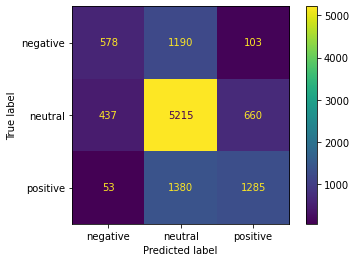

<Figure size 1080x1080 with 0 Axes>

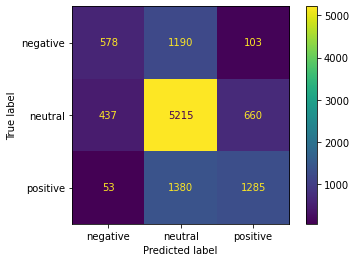

<Figure size 1080x1080 with 0 Axes>

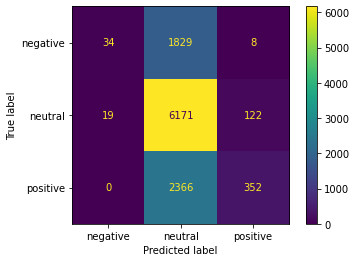

<Figure size 1080x1080 with 0 Axes>

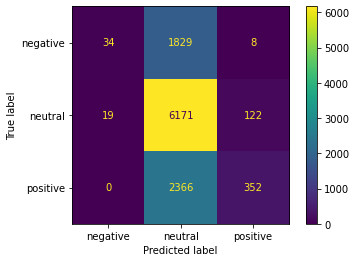

<Figure size 1080x1080 with 0 Axes>

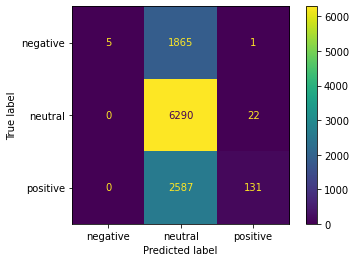

<Figure size 1080x1080 with 0 Axes>

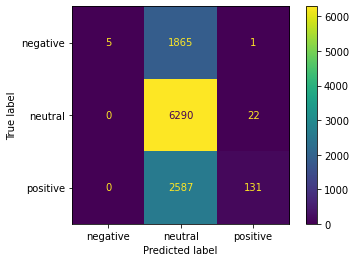

<Figure size 1080x1080 with 0 Axes>

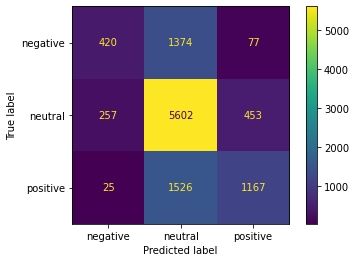

<Figure size 1080x1080 with 0 Axes>

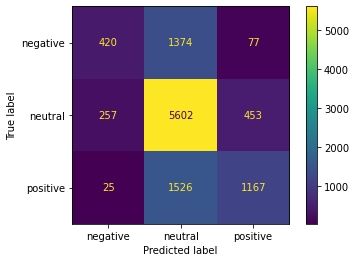

In [235]:
# devise a list of models to test
models = [LinearSVC(), BernoulliNB(), MultinomialNB(), LogisticRegression(C=2, n_jobs=-1)]

for m in models:
    evaluate(m, X, y, cv=2)